<a href="https://colab.research.google.com/github/antahiap/dsr-nlp/blob/main/notebooks/01_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Runtime setting for T4

In [1]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(    # unonomus variable
            "mnist",
            split=["train", "test[:50%]",  "test[50%:]"],
            as_supervised=True, # not activeated, the data will be as dict, now as tuple
            with_info =True    #
)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

- how many data per claas for "training" a DL, 10k and transfer learning around 1k (deppending on the model)
- if little data, skip validation and keep test, validation leak into the training
- test set to evalute how good model perform on unseen data and not overfit to seen data
- validation, use during training to evaluate the performance of the model during the training and save the best model.
- kfault cross validation and data leakage is not a problem with LLMs
- good aplit, 70,10, 20, train-valid-test.
- if don't randomize the train data, shuffle, we will overfit on the order of the data
- `.take` with shuffle goes with uniform probability selection, without is just the first ones
- `.shuffle` increasing the number will make it to break due to error, try to maximize as long as the memory don't collapse

In [3]:
!nvidia-smi

Mon Aug  7 13:54:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    389MiB / 15360MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

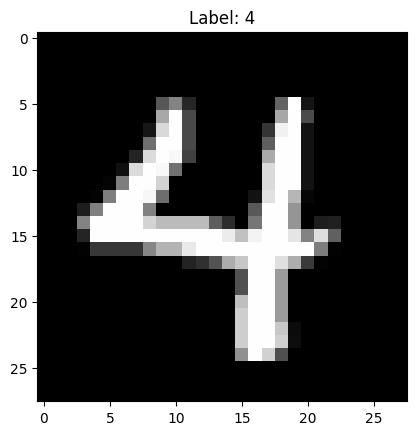

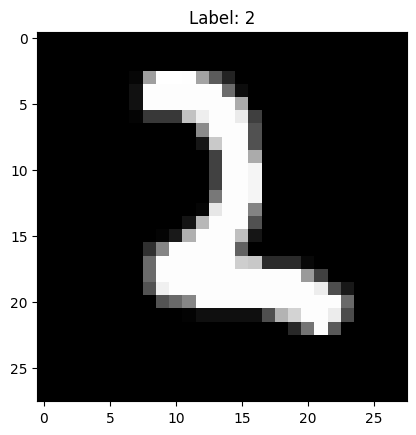

In [4]:
for x, y in dataset_train_original.shuffle(6000).take(2): # Chaining pattern
  plt.imshow(x, cmap="gray") # "inferno")
  plt.title(f"Label: {y}")
  plt.show()

- minibatch-GD, good to smoothen the loss curve, keep power 2, due to better distribution
- including all, will too smooth the loss curve


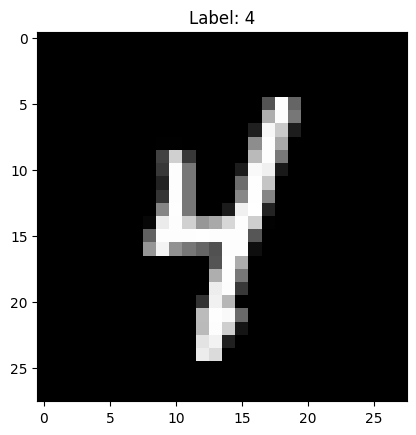

<dtype: 'float32'>


In [5]:
def encode(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # normalisation and the data type,
                                                          # float 32 as GPU is developed for it, if using float64 it will down cast
  return image, label

dataset = dataset_train_original.map(lambda image, label:encode(image, label))  # lmbda, anonymus function

for image, label in dataset.take(1):
  plt.imshow(image, cmap="gray")
  plt.title(f'Label: {label}')
  plt.show()
  print(image.dtype)

In [6]:
# Data set for training
# - shuffle,
# - normalize,
# - batch

dataset_train = dataset_train_original.map(lambda x, y: encode(x, y)).shuffle(60_000).batch(128)

for x, y in dataset_train.take(1):
  print(x.shape)
  print(y.shape)

(128, 28, 28, 1)
(128,)


In [7]:

dataset_train = dataset_train_original.map(lambda x, y: encode(x, y)).cache().shuffle(60_000).batch(128) # adding cache to make it faster, depending on the encoding function

dataset_validate = dataset_validate_original.map(lambda x, y: encode(x, y)).cache().batch(128)           # using batch for parallelisation

dataset_test = dataset_test_original.map(lambda x, y:encode(x, y))
dataset_test = dataset_test.cache()
dataset_test = dataset_test.batch(128)

# Model
Here the 1st output is None, to make it work with batch size.

In [8]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


## Activation
- tanh from -1 to 1
- Diff of softmax with sigmoid, relue:
  - softmax ensure that the sum of value is 1 > distribution of probability
  - if binary classification, using softmax, will always predict 1 with accuracy of 50%, better to use sigmoid.

- tanh is a bit more expensive than sigmoid
- tanh might be good for regression, driving steering wheel.

In [9]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


# Evaluate Model

In [10]:
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",   # smae as nllloss in pytorch
    metrics=['accuracy']                        # good for communication
)

In [11]:
loss, accuracy = model.evaluate(dataset_train)
loss, accuracy

469/469 [==============================] - 4s 2ms/step - loss: 2.3992 - accuracy: 0.1005


(2.3991570472717285, 0.10045000165700912)

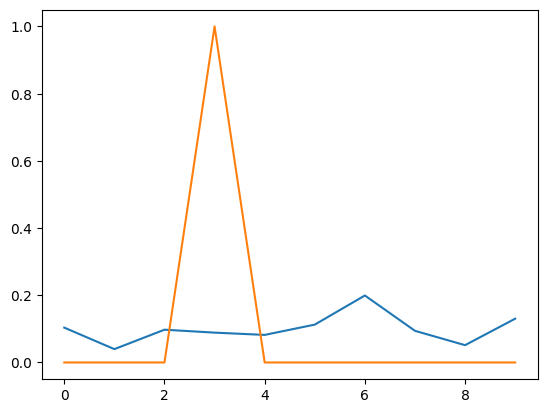

In [12]:
for x_batch, y_batch in dataset_train.take(1):
  prediction = model.predict(x_batch, verbose=0)
  index=0
  plt.plot(prediction[index])
  y_batch_onehot = tf.keras.utils.to_categorical(y_batch)
  plt.plot(y_batch_onehot[index])

In [13]:
history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validate
)

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.4248 - accuracy: 0.8837 - val_loss: 0.2356 - val_accuracy: 0.9304
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2033 - accuracy: 0.9419 - val_loss: 0.1837 - val_accuracy: 0.9468
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1569 - accuracy: 0.9544 - val_loss: 0.1515 - val_accuracy: 0.9564
Epoch 4/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1292 - accuracy: 0.9630 - val_loss: 0.1307 - val_accuracy: 0.9610
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1087 - accuracy: 0.9689 - val_loss: 0.1221 - val_accuracy: 0.9628
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0948 - accuracy: 0.9730 - val_loss: 0.1149 - val_accuracy: 0.9646
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0831 - accuracy: 0.9758 - val_loss: 0.1077 - val_accuracy: 0.9678
Epoch 

In [14]:
history.history.keys()
# model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

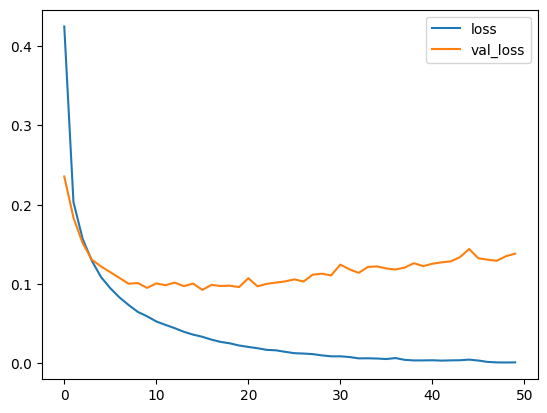

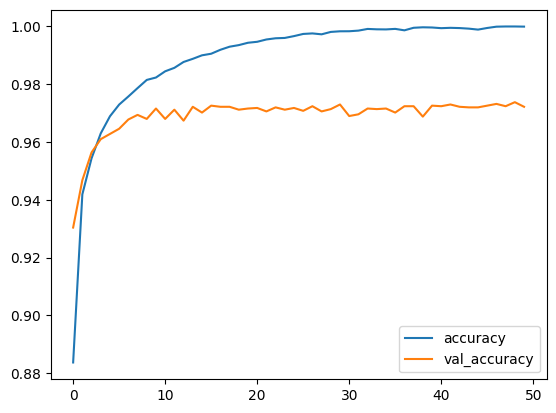

In [20]:
def render_history(history):
  assert isinstance(history, dict), f"Expected dict, but got {type(history)}"

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(history['accuracy'], label="accuracy")
  plt.plot(history['val_accuracy'], label="val_accuracy")
  plt.legend()

render_history(model.history.history)